In [1]:
# lading the python NWB API
import pynwb, os, sys
import numpy as np # numpy for numerical analysis
import matplotlib.pylab as plt # + matplotlib for vizualization

from datavyz import ge

sys.path.append(os.path.join(os.path.expanduser('~'), 'physion', 'physion'))
from dataviz.show_data import MultimodalData 
from analysis.read_NWB import scan_folder_for_NWBfiles, DummyParent, read

Experiment & Visual-Stim modules disabled !


## Setting the datafolder

In [2]:
FILES, DATES, SUBJECTS = scan_folder_for_NWBfiles(os.path.expanduser('~'), 'DATA')
print('Subjects: ')
for s in np.unique(SUBJECTS):
    print(' -', s)

inspecting the folder "/Users/aurelien.corrado" [...]
No data_type found for builder root

 /!\ Pb with "/Users/aurelien.corrado/DATA/2021_05_31/2021_05_31-16-46-06.nwb" 

 -> found n=34 datafiles 
Subjects: 
 - Mouse1_SSTCreEphys
 - Mouse1_SSTCreTdTomato
 - Mouse2_SSTCreEphys
 - Mouse2_SSTCreTdTomato
 - Mouse3_SSTCreEphys
 - N/A


In [7]:
SUBJECTS

array(['Mouse3_SSTCreEphys', 'Mouse3_SSTCreEphys', 'Mouse3_SSTCreEphys',
       'Mouse3_SSTCreEphys', 'Mouse3_SSTCreEphys', 'Mouse3_SSTCreEphys',
       'Mouse3_SSTCreEphys', 'Mouse3_SSTCreEphys', 'Mouse3_SSTCreEphys',
       'Mouse3_SSTCreEphys', 'Mouse3_SSTCreEphys', 'Mouse3_SSTCreEphys',
       'Mouse3_SSTCreEphys', 'N/A', 'Mouse3_SSTCreEphys',
       'Mouse2_SSTCreTdTomato', 'Mouse2_SSTCreTdTomato',
       'Mouse1_SSTCreTdTomato', 'Mouse2_SSTCreTdTomato',
       'Mouse2_SSTCreTdTomato', 'Mouse1_SSTCreEphys',
       'Mouse2_SSTCreEphys', 'Mouse2_SSTCreTdTomato',
       'Mouse3_SSTCreEphys', 'Mouse3_SSTCreEphys',
       'Mouse1_SSTCreTdTomato', 'Mouse3_SSTCreEphys',
       'Mouse2_SSTCreTdTomato', 'Mouse1_SSTCreTdTomato',
       'Mouse2_SSTCreTdTomato', 'Mouse3_SSTCreEphys',
       'Mouse1_SSTCreTdTomato', 'Mouse1_SSTCreTdTomato',
       'Mouse1_SSTCreTdTomato'], dtype='<U21')

## Single Recording Analysis

In [25]:

def summary_figure(filename, mouse_name = None, tzoom=[100,120]):
    
    # load datafile
    io = pynwb.NWBHDF5IO(filename, 'r')
    nwbfile = io.read() # don't forget to close afterwards !! (io.close() )
    if mouse_name is None:
        mouse_name = nwbfile.subject.subject_id
    # build full figure
    fig, AX = ge.figure(axes_extents=[[[4,1]],[[4,2]],[[1,1],[1,1],[1,1],[1,1]]], wspace=1.5)
    [ax_full], [ax_zoom], [ax_runningHist, ax_facemvtHist, ax_pupilHist, ax_eyePos] = AX
    # running
    ge.hist(nwbfile.acquisition['Running-Speed'].data[:], ax=ax_runningHist)
    ge.set_plot(ax_runningHist, yticks=[], ylabel='count (norm.)', xlabel='speed (cm/s)', title='running')
    # whisking
    if 'FaceMotion' in nwbfile.processing:
        ge.hist(nwbfile.processing['FaceMotion'].data_interfaces['face-motion'].data[:], ax=ax_facemvtHist)
    else:
        ge.annotate(ax_facemvtHist, 'absent', (0.5, 0.5), ha='center', va='center', size='small')
    ge.set_plot(ax_facemvtHist, yticks=[], ylabel='count (norm.)', xlabel='motion (a.u.)', title='whisking')

    # pupil
    cond = np.isfinite(nwbfile.processing['Pupil'].data_interfaces['sx'].data[:])
    diameter = np.max([nwbfile.processing['Pupil'].data_interfaces['sx'].data[cond],
            nwbfile.processing['Pupil'].data_interfaces['sy'].data[cond]], axis=0)
    ge.hist(diameter, ax=ax_pupilHist)
    ge.set_plot(ax_pupilHist, ylabel='count (norm.)', xlabel='diam. (mm)', title='pupil')
    # eye position
    x = nwbfile.processing['Pupil'].data_interfaces['cx'].data[cond][::10]
    y = nwbfile.processing['Pupil'].data_interfaces['cy'].data[cond][::10]
    ge.scatter(x-x.mean(),y-y.mean(), ax=ax_eyePos, color=ge.blue)
    ge.set_plot(ax_eyePos, xlabel='$\delta$x (mm)', ylabel='$\delta$y (mm)', title='eye position')
    
    ge.annotate(fig, mouse_name+'  -- '+filename, (1,1), va='top', ha='right', size='small')
    
    data = MultimodalData(filename)
    
    # full view
    plot_settings = {'settings':{'Locomotion':dict(fig_fraction=1, subsampling=10),
                                 'Pupil':dict(fig_fraction=2, subsampling=10,)},'Tbar':20}
    if 'FaceMotion' in nwbfile.processing:
        plot_settings['settings']['FaceMotion'] = dict(fig_fraction=1, subsampling=10)
    _ = data.plot_raw_data(data.tlim, ax=ax_full, **plot_settings)
    ge.annotate(ax_full, 'full recording', (1,1), ha='right', va='top', size='large')
    ax_full.fill_between(tzoom, ax_full.get_ylim()[0]*np.ones(2), ax_full.get_ylim()[1]*np.ones(2),
                        color='gray', alpha=.2, lw=0)
    
    # zoomed view
    plot_settings = {'settings':{'Locomotion':dict(fig_fraction=1, subsampling=1),
                                 'Pupil':dict(fig_fraction=2, subsampling=1,)},'Tbar':1}
    if 'FaceMotion' in nwbfile.processing:
        plot_settings['settings']['FaceMotion'] = dict(fig_fraction=1, subsampling=1)

    _ = data.plot_raw_data(tzoom, ax=ax_zoom, **plot_settings)
    ge.annotate(ax_zoom, 'zoom', (1,1), ha='right', va='top', size='large')
    
    # close datafile
    io.close()
    return fig, AX

[41, 250, 627, 515]


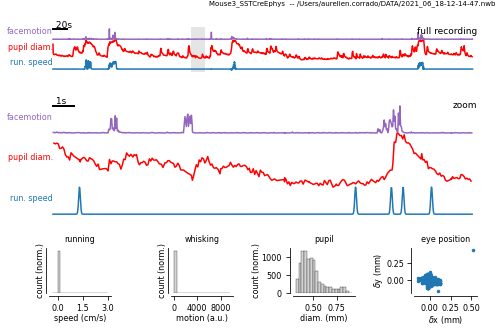

In [45]:
fig, AX = summary_figure(FILES[10], tzoom=[200,220])
ge.save_on_desktop(fig, 'fig.png')

## Population Analysis of the Habituation Process

In [32]:
class Parent:
    def __init__(self):
        pass
    
def summary_quantity_per_recordings(filename):
    
    parent = Parent()
    read(parent, filename)

    output = {}

    # rec time
    output['rec-time'] = parent.tlim[1]-parent.tlim[0]
    
    # running
    output['mean-speed'] = np.mean(parent.nwbfile.acquisition['Running-Speed'].data[:])
    
    # facemotion
    #output['mean-facemotion'] = np.mean(parent.nwbfile.processing['FaceMotion'].data_interfaces['face-motion'].data[:])

    # pupil
    #diameter = np.max([parent.nwbfile.processing['Pupil'].data_interfaces['sx'].data[:],
    #        parent.nwbfile.processing['Pupil'].data_interfaces['sy'].data[:]], axis=0)
    #output['mean-pupil'] = np.mean(diameter)

    return output

output = summary_quantity_per_recordings(FILES[0])

[64, 246, 604, 527]


[64, 246, 604, 527]
[154, 243, 485, 414]
[313, 247, 368, 617]
[299, 256, 382, 599]
[289, 228, 385, 667]
[180, 42, 449, 581]
[169, 30, 499, 627]
[171, 84, 478, 568]
[199, 147, 420, 493]
[174, 36, 504, 546]
[220, 186, 445, 423]
[64, 246, 604, 527]
[53, 262, 615, 500]
[18, 273, 646, 488]
[176, 281, 496, 477]
[223, 285, 449, 477]
[204, 301, 465, 453]
[22, 239, 635, 531]
[37, 254, 631, 496]
[49, 319, 495, 407]
[41, 250, 627, 515]
[49, 289, 611, 477]
[204, 301, 480, 465]
[22, 285, 650, 461]


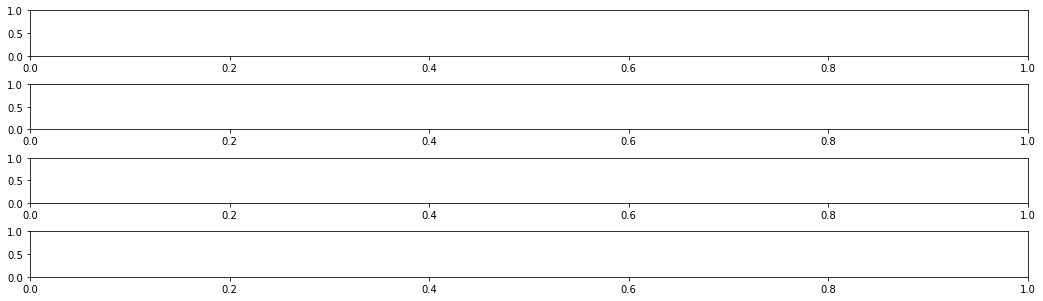

In [33]:
def convert_date_to_days(datestring):
    x = datestring.split('_')
    return int(x[0]*365)+int(x[1]*31)+int(x[2])
dDATES = np.array([convert_date_to_days(d) for d in DATES])


fig, AX = ge.figure(axes=(1,4), figsize=(4,1))

summary = {}
output = summary_quantity_per_recordings(FILES[0]) # 

for iS, s in enumerate(np.unique(SUBJECTS)):
    # looping over subjects
    s_cond = (SUBJECTS==s)
    summary[s] = {'day':[]}
    for key in output:
        summary[s][key] = []
        
    sFILES, sDATES = FILES[s_cond], dDATES[s_cond]
    startDate = np.min(sDATES) # starting habituation day
    for iD, d in enumerate(np.unique(sDATES)):
        # looping over days
        d_cond = (sDATES==d)
        sdFILES, sdDATES = sFILES[d_cond], sDATES[d_cond]
        summary[s]['day'].append(d-startDate+1) # starting at one
        for key in output:
            summary[s][key].append(0.) # initializing to 0, then added per-file contrib
        for f in sdFILES:
            outputF = summary_quantity_per_recordings(f)
            for key in outputF:
                summary[s][key][-1] += outputF[key]/len(sdFILES)
   

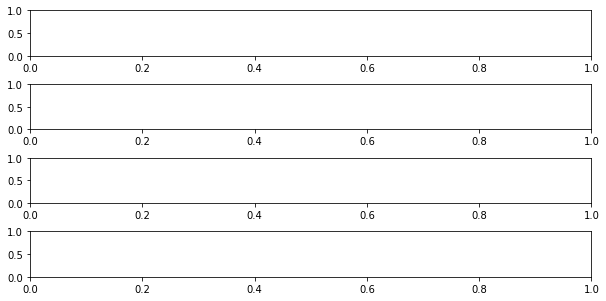

In [19]:
fig, AX = ge.figure(axes=(1,4), figsize=(3,1))
